In [4]:
import matplotlib.pyplot as plt
import cyipopt as ipopt
import numpy as np

from vessel_models import VesselModel
from controller import MPC

In [5]:
# Simulation variables
N = 100
dt = 0.1
ns = 6
nu = 3

N_mpc = 15 # default 10
N_sim = N + N_mpc

# Cost matrices
Qvec = 0.1*np.ones(ns) # default 3
Rvec = np.ones(nu)
Qfvec = 10*np.ones(ns)

# Reference trajectory
Sload = np.loadtxt('dircol_soln.csv', delimiter=',')
Sf = Sload[-1]
Sref = np.tile(Sf, (N_sim, 1))
Sref[:N] = Sload

# Obstacle States
num_obstacles = 2
obstacles = np.zeros((num_obstacles,6))
radii = np.zeros(num_obstacles)
obstacles[0, 0:2] = [0.25, 0.25]
obstacles[1, 0:2] = [0.75, 0.75]
radii[0] = 0.10
radii[1] = 0.10

model = VesselModel(mismatch=False)
print(model.m)

23.8


In [6]:
U_soln = np.zeros((N-1, nu))
S_soln = np.zeros((N, ns))
S_soln[0] = Sref[0]

for i in range(N-1):
    s0 = S_soln[i]
    #sf = Sref[i+N_mpc-1] # use for solving following a trajectory
    sf = Sref[-1] # use for solving a problem without an existing trajectory
    sref = Sref[i:i+N_mpc]
    trajoptimizer = MPC(model, N_mpc, ns, nu, dt, Qvec, Rvec, Qfvec, s0, sf, sref, obstacles, radii)
    trajoptimizer.exec_MPC()
    S, U = trajoptimizer.flat2vec(trajoptimizer.sol.x)
    U_soln[i] = U[0]
    S_soln[i+1] = model.rk4(s0, U[0], dt)
    

This is Ipopt version 3.14.17, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:    12672
Number of nonzeros in inequality constraint Jacobian.:    15048
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      132
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       96
Total number of inequality constraints...............:      114
        inequality constraints with only lower bounds:      114
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.5000000e+00 1.00e+00 3.20e-03   0.0 0.00e+00    -  0.00e+00 0.00e+00   0
   

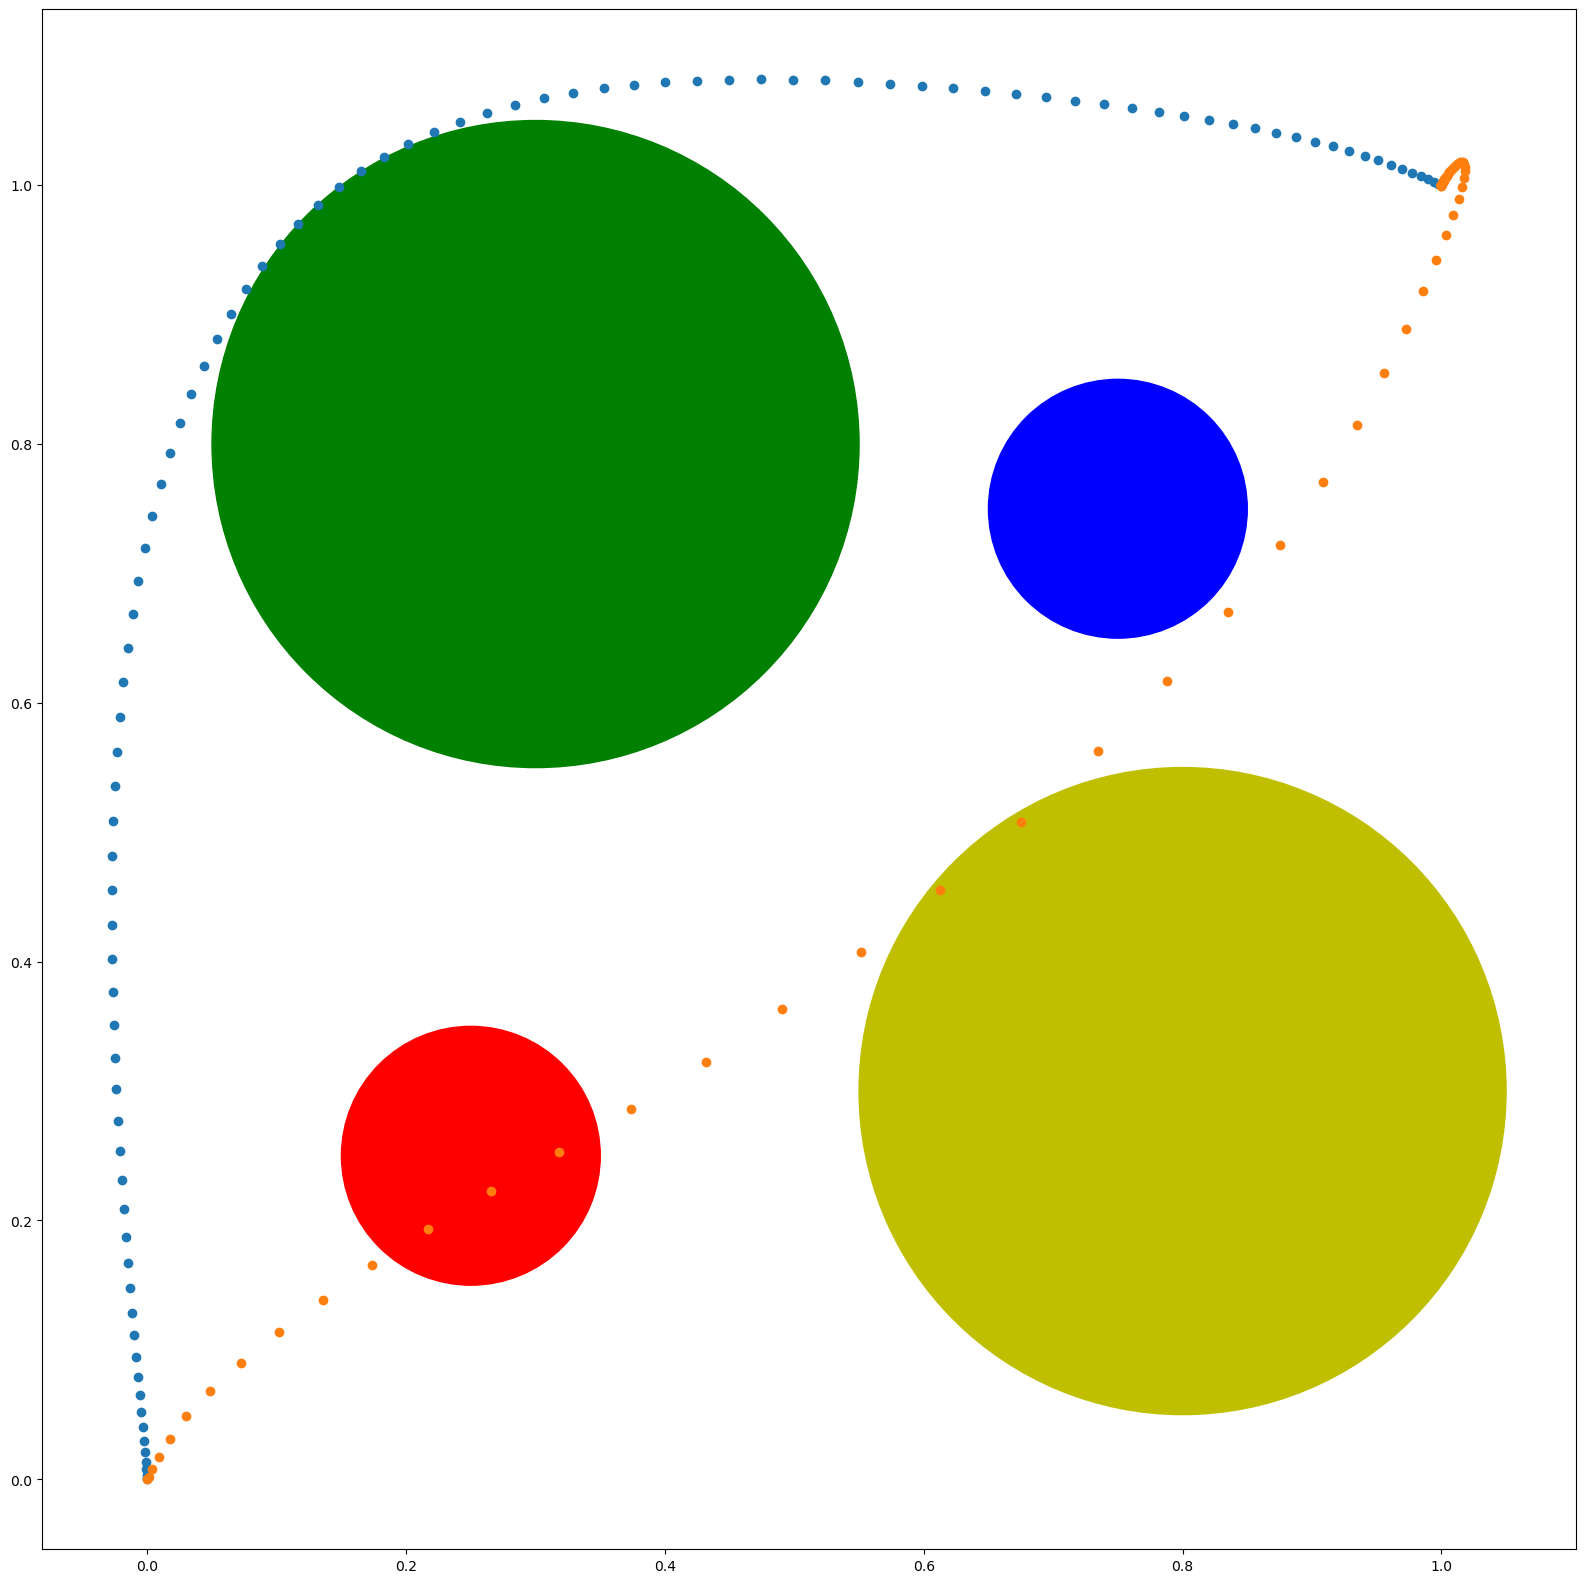

In [7]:
Sfwd = np.zeros((N,ns))
Sfwd[0] = Sref[0]
for i in range(N-1):
    Sn = Sfwd[i]
    Un = U_soln[i]
    Sfwd[i+1] = model.rk4(Sn, Un, dt)

#ps = Sfwd.T
ps = S_soln.T
ps_ref = Sref.T
fig, axes = plt.subplots(1, 1, figsize=(20, 20))
circle1 = plt.Circle((0.25, 0.25), 0.1, color='r')
circle2 = plt.Circle((0.3, 0.8), 0.25, color='g')
circle3 = plt.Circle((0.75, 0.75), 0.1, color='b')
circle4 = plt.Circle((0.8, 0.3), 0.25, color='y')
axes.add_patch(circle1)
axes.add_patch(circle2)
axes.add_patch(circle3)
axes.add_patch(circle4)
axes.scatter(ps_ref[1], ps_ref[0])
axes.scatter(ps[1], ps[0])
axes.set_aspect('equal', adjustable='box')
plt.show()